# Морфология 2
В данном ноутбуке находится задание на триграммы и словарь. В качестве текста будем использовать томик войны и мира: https://goo.gl/qcVTLE 

Для начала напомним некоторые полезные инструменты на питоне

## 1. Инструменты

### 1.1. Регулярные выражения
Исчерпывающий пост https://habr.com/ru/post/349860/

In [1]:
import re

# С помощью рег. выражения можно искать, заменять и сентезировать строки по шаблонам
# Парочка простых примеров
numbers = re.findall(r'\d+', r'There is some numbers: 49 and 432')
print (u'Находим числа в строке: ', numbers)

print  (u'Простенький токенизатор: ', re.sub('[,\.?!]',' ','How, to? split. text!').split())

print (u'Еще один токенизатор: ', re.split(r'\W+', 'How, to? split. text! Again'))

# в качестве тренировки придумайте свой токенизатор в случае, когда из текста нужно получить только русские слова.

Находим числа в строке:  ['49', '432']
Простенький токенизатор:  ['How', 'to', 'split', 'text']
Еще один токенизатор:  ['How', 'to', 'split', 'text', 'Again']


### 1.2. Чтение файлов
Чтобы не мучится самим с кодировками, приведем способ чтения файла корпуса.

In [2]:
import io
wordlilist = None

with open('wp.txt', "r") as text_file:
    text = text_file.read()
    # wordlist = Здесь заиспользуем токенизатор. Также приведем все слова к нижнему регистру.


### 1.3. ООП
В питоне можно создавать свои классы, скорее всего нам понадобится класс для хранения бора

In [38]:
class Node:
    def __init__(self, name):
        self.name = name
        self.counts = 1
        self.nodes = []
        
    def find_node(self, name):
        if len(self.nodes) == 0:
            return None
        
        for node in self.nodes:
            if node.name == name:
                return node
            
        return None
    
    def append(self, node):
        self.nodes.append(node)
        self.count()
        return self.nodes
    
    def count(self):
        self.counts += 1
        
    def get_most_probable_node(self, n=1):
        sorted_nodes = sorted(self.nodes, key=lambda node: node.counts, reverse=True)
        return sorted_nodes[:n]
    
def build_bor(tokens):
    firstNode = Node('#')
    
    for token in tqdm.tqdm_notebook(tokens):
        token = token.lower()
        token = token+"#"
        root = firstNode
        
    for c in token:
        node = root.find_node(c)
            
        if node is not None:
            node.count()
            root = node
        else:
            newNode = Node(c)
            root.append(newNode)
            root = newNode

    return firstNode
    
# все данные хранятся в self, поэтому он и передается первым аргументом во все методы

### 1.4. pyplot
Довольно часто приходится построить какие-нибудт графики и гистограммы для изучения данных, с которыми придется работать. Для этого в питоне есть удобнейший модуль для этого - pyplot. Туториал: https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html

In [4]:
#!pip install matplotlib # Установка модуля
import matplotlib.pyplot as plt
# команда чтобы картинки рисовались прямо в ноутбуке
%matplotlib inline 

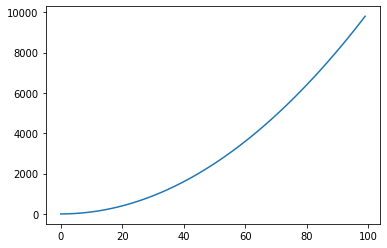

In [5]:
# Посмотрим на график функции x^2
data = [i * i for i in range(100)]
plt.plot(data)

(array([32., 13., 10.,  8.,  8.,  6.,  6.,  6.,  5.,  6.]),
 array([   0. ,  980.1, 1960.2, 2940.3, 3920.4, 4900.5, 5880.6, 6860.7,
        7840.8, 8820.9, 9801. ]),
 <a list of 10 Patch objects>)

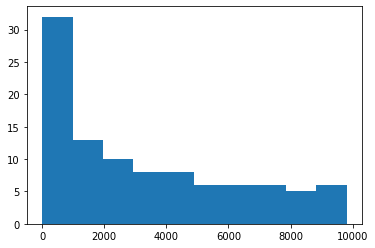

In [6]:
# и распределение по значениям
plt.hist(data)

Также полезная команда для подсчета времения выполнеия в ячейке

In [7]:
%%time
res = 0
for i in range(int(1e8)):
    res += 1

CPU times: user 6.63 s, sys: 0 ns, total: 6.63 s
Wall time: 6.62 s


## 2. Задание
Собственно теперь нам потребуется написать подсчет триграмм и бор для словаря, чтобы реализовать простенькую систему исправления ошибок.

### 2.1. Триграммы
Для начала получим словарь триграмма - её кол-во в тексте, не забывая о начале и конце слова.

Далее можно построить гистограмму на кол-во вхождений триграмм, и посмотреть самые частые и какая частота у каких-нибудь заведомо странных, например: 'чгк', 'шкя' и подобные. Из полученных данных придумать эвристику, как считать слово с опечаткой. Проверить эвристику по словарю.

In [8]:
import collections

In [9]:
def tokenize(text):
    return re.findall(r'[а-яА-Я]+', text)

In [60]:
def corpus_trigrams(word_list):
    '''returns trigrams count dictionary'''
    trigrams = []

    for word in word_list:
        for i in range(len(word) - 2):
            trigrams.append(word[i:i+3].lower())
            
    dictionary = collections.Counter(trigrams)
    total = sum(list(dictionary.values()))
    for key in dictionary.keys():
        dictionary[key] = dictionary[key]/total
        
    return dictionary

def is_error(word, dictionary):
    '''is the word with mistake'''
    
    eps = 1e-10
    
    if word in dictionary:
        return False
    
    mean_prob = 0
    
    for i in range(len(word) - 2):
        ngram = word[i:i+3]
        mean_prob += dictionary.get(word[i:i+3], 0)
    if mean_prob < 0.005:
        return True
    return False


In [11]:
token_text = [s.lower() for s in tokenize(text)]
counter = corpus_trigrams(token_text)

In [12]:
counter.get("корова")

In [13]:
word = "карова"
print(is_error(word, counter))
word = "корова"
print(is_error(word, counter))

0.00434418108375886
True
0.0076975840256078044
False


### 2.2. Бор
Далее построим бор, с помощью которого будем искать исправления опечатки в слове. Пока только в случае замены и удаления в конце (Если есть желание, то можно и для всех случаев). Также сравнить по времени с поиском в случае замены в исходном слове последних двух символов и поиске в словаре.

In [14]:
import Levenshtein

In [42]:
def correct_word(word, dictionary):
    '''returns most similar word from dictionary'''
    max_similarity = 0
    most_similar_word = None
    
    for word_d in dictionary:
        similarity = Levenshtein.ratio(word, word_d)
        if similarity > max_similarity:
            most_similar_word = word_d
            max_similarity = similarity
            
    return most_similar_word
    
def correct_word_naive(word, bor, dictionary):
    '''correct word using generation'''
    if word in dictionary:
        return word
            
    similarity = 0
    node = bor
    prefix = ""
    
    for s in word:
        new_node = node.find_node(s)
        if new_node is not None:
            similarity += 1
            prefix += s
            node = new_node
        else:
            break
            
    suffix = ""
    
    while True:
        node = node.get_most_probable_node()[0]
        if node.name != "#":
            suffix += node.name
        else:
            break
    
    return prefix + suffix


In [16]:
correct_word("двирь", token_text)

'дверь'

In [17]:
import tqdm

In [18]:
num_tokens = None

bor = build_bor(token_text[:num_tokens])

/home/daria/Documents/ABBYY/env/lib/python3.6/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [19]:
correct_word_naive("дверь", bor, token_text)

'дверь'

In [45]:
correct_word_naive("жетелей", bor, token_text)

'жителей'

### 2.3 Все вместе
Теперь соберем поиск и исправление опечаток в одну систему, которая будет принимать текст и править его. Также замерим скорость по сравнению с "менее наивным подходом".

In [70]:
def correct_mistakes(text, dictionary):
    '''returns corrected text'''
    token_text = tokenize(text)
    corrected_text = []
    
    for word in token_text:
        counter = corpus_trigrams(dictionary)
        if is_error(word, counter):
            word = correct_word(word, dictionary)
        corrected_text.append(word)
        
    return " ".join(corrected_text)

def correct_mistakes_naive(text, bor, dictionary):
    '''returns corrected text using generation'''
    token_text = tokenize(text)
    corrected_text = []
    
    for word in token_text:
        counter = corpus_trigrams(dictionary)
        if is_error(word, counter):
            word = correct_word_naive(word, bor, dictionary)
        corrected_text.append(word)
        
    return " ".join(corrected_text)

In [73]:
%%time
sample_text = "двирь закрыл на нычь"
correct_mistakes(sample_text, token_text)

CPU times: user 547 ms, sys: 0 ns, total: 547 ms
Wall time: 546 ms


'дверь закрыл на ночь'

In [65]:
prefix_tree = build_bor(token_text)

/home/daria/Documents/ABBYY/env/lib/python3.6/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [72]:
%%time
sample_text = "двирь закрыл на нычь"
correct_mistakes_naive(sample_text, prefix_tree, token_text)

CPU times: user 494 ms, sys: 0 ns, total: 494 ms
Wall time: 492 ms


'жителей закрыл на жителей'